# Electric Motor Ambient Temprature Prediction

# Features Description: 

- ambient = Ambient temperature as measured by a thermal sensor located closely to the stator.

- coolant = Coolant temperature. The motor is water cooled. Measurement is taken at outflow.

- u_d = Voltage d-component

- u_q = Voltage q-component

- motor_speed = Motor speed

- torque= Torque induced by current.

- i_d = Current d-component

- i_q = Current q-component

- pm = Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.

- stator_yoke = Stator yoke temperature measured with a thermal sensor.

- stator_tooth = Stator tooth temperature measured with a thermal sensor.

- stator_winding = Stator winding temperature measured with a thermal sensor.

- profile_id = Each measurement session has a unique ID. Make sure not to try to estimate from one session onto the other as they are strongly independent.

# Import packages: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from scipy import stats
from sklearn.metrics import mean_squared_error

# Import data:

In [2]:
df = pd.read_csv('pmsm_temperature_data.csv')

df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


# Exploratory data analysis:

In [3]:
#Looking at how our data looks
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


In [4]:
#Checking the shape of our dataset
df.shape


(998070, 13)

In [5]:
df.isnull().values.any()

False

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B0B46F198>,
      dtype=object)

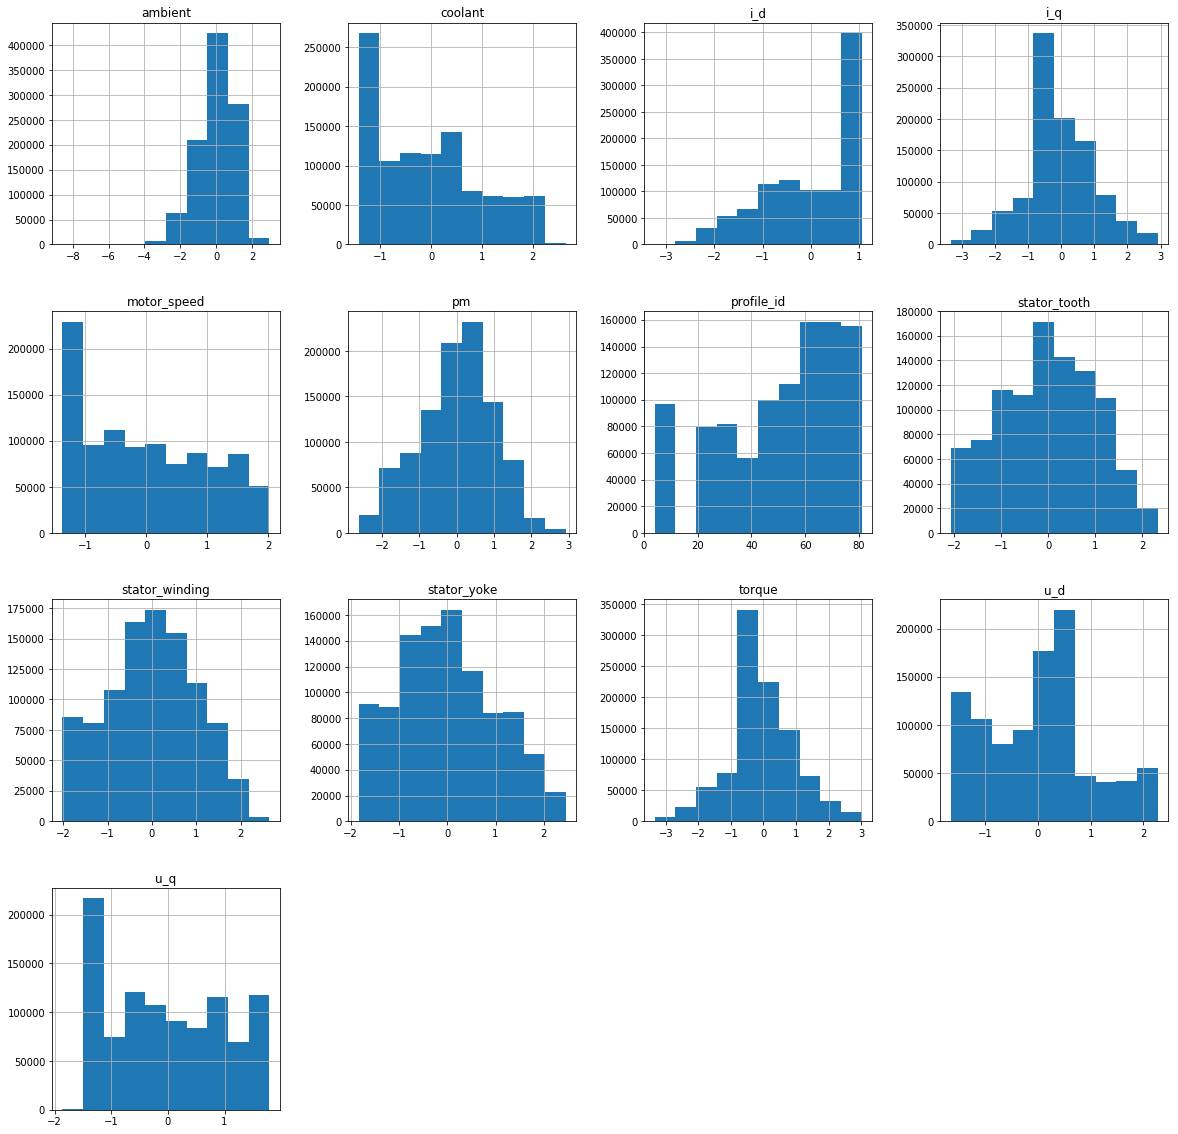

In [6]:
df.hist(figsize = (20,20))


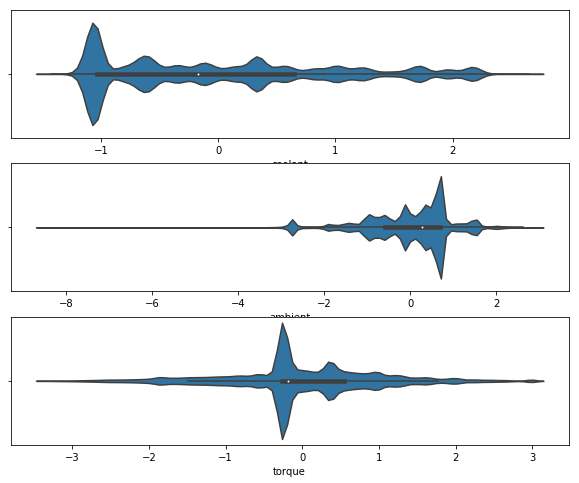

In [7]:
column = ['coolant', 'ambient', 'torque']
fig, axes = plt.subplots(nrows=3, figsize=(10,8))
fig.subplots_adjust(hspace=0.2)

for (ax, i) in zip(axes, column):
    sns.violinplot(x=df[i], ax=ax)
    plt.plot()

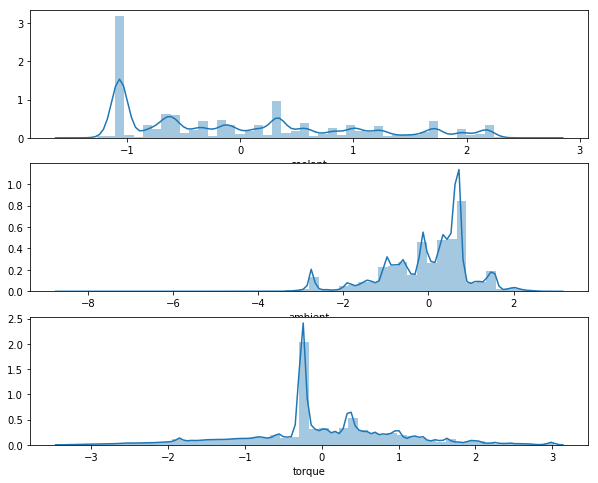

In [8]:
fig, axes = plt.subplots(nrows=3, figsize=(10,8))
fig.subplots_adjust(hspace=0.2)

for (ax, i) in zip(axes, column):
    sns.distplot(df[i], ax=ax)
    plt.plot()

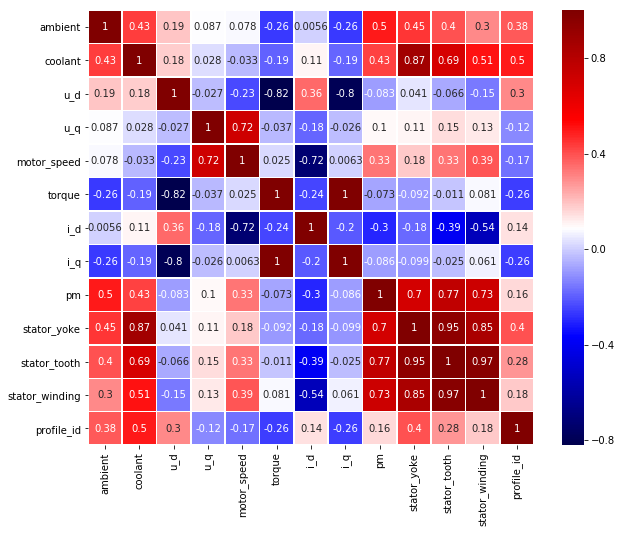

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap = 'seismic')

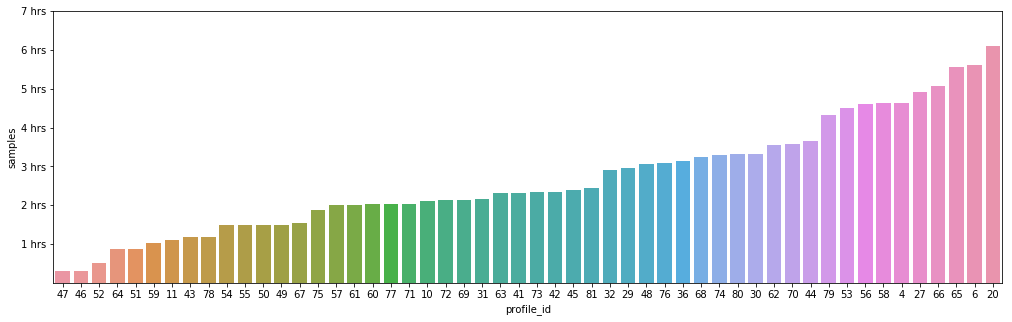

In [10]:
fig = plt.figure(figsize=(17, 5))
grpd = df.groupby(['profile_id'])
_df = grpd.size().sort_values().rename('samples').reset_index()
ordered_ids = _df.profile_id.values.tolist()
sns.barplot(y='samples', x='profile_id', data=_df, order=ordered_ids)
tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{a} hrs' for a in range(1, 8)])

# Data Preprocessing 

In [11]:
df.drop('profile_id',axis=1,inplace=True)

In [12]:
df.skew()

ambient          -0.848914
coolant           0.628247
u_d               0.194644
u_q               0.199885
motor_speed       0.333305
torque           -0.042660
i_d              -0.622578
i_q              -0.075705
pm               -0.232903
stator_yoke       0.257297
stator_tooth     -0.061533
stator_winding   -0.028055
dtype: float64


Skewness of ambient and coolant readings are a little over normal distribution's requirements

In [13]:

df.kurtosis()

ambient           0.822427
coolant          -0.759946
u_d              -0.522858
u_q              -1.271316
motor_speed      -1.166937
torque            0.779318
i_d              -0.754100
i_q               0.784974
pm               -0.349213
stator_yoke      -0.728963
stator_tooth     -0.779987
stator_winding   -0.728416
dtype: float64

Kurtosis of ambient, i_q, torque is Leptokurtic. All the other features show Playtkurtic nature.

In [14]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

ambient           1.286061
coolant           1.688634
u_d               1.184850
u_q               1.780015
motor_speed       1.805475
torque            0.814088
i_d               1.770271
i_q               0.756529
pm                1.352999
stator_yoke       1.444610
stator_tooth      1.534190
stator_winding    1.451282
dtype: float64


(814996, 12)

In [15]:

df.skew()

ambient          -0.360192
coolant           0.589342
u_d               0.003343
u_q               0.032007
motor_speed       0.190497
torque            0.269678
i_d              -0.801179
i_q               0.263415
pm               -0.171888
stator_yoke       0.302314
stator_tooth      0.000036
stator_winding    0.026102
dtype: float64

Improved skewness due to outlier removal

# Regressors

In [16]:
#Assigning X and y values for machine learning
X = df.iloc[:,1:12].values
y = df.iloc[:,0:1].values

In [17]:
X

array([[-1.1184461 ,  0.3279352 , -1.2978575 , ..., -1.8314217 ,
        -2.0661428 , -2.0180326 ],
       [-1.1170206 ,  0.3296648 , -1.2976865 , ..., -1.8309687 ,
        -2.0648587 , -2.0176313 ],
       [-1.1166813 ,  0.3327715 , -1.3018217 , ..., -1.8304    ,
        -2.064073  , -2.0173435 ],
       ...,
       [ 0.30741498,  0.33094567, -1.2468519 , ...,  1.0029056 ,
         0.8339357 ,  0.492666  ],
       [ 0.3020816 ,  0.33098695, -1.2495048 , ...,  0.99915737,
         0.8305043 ,  0.490581  ],
       [ 0.3126659 ,  0.33082953, -1.2465905 , ...,  0.98716253,
         0.8280457 ,  0.48938242]])

In [18]:
y

array([[-0.75214297],
       [-0.77126324],
       [-0.78289163],
       ...,
       [-0.0423501 ],
       [-0.03943322],
       [-0.04380252]])

In [19]:
name = []
score = []
rmse = []

## Random Forest Regressor

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [21]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)
regressor.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
y_pred = regressor.predict(X_train)
y_pred

array([-0.11871311,  0.17408729,  1.69107865, ...,  0.38471696,
        1.01652124, -0.14433961])

In [23]:
#Root Mean Squared Error for Train
RMSE=np.sqrt(mean_squared_error(y_train,y_pred))
RMSE

0.030098595255360332

In [24]:
metrics.r2_score(y_train,y_pred) 

0.9987246570967228

In [25]:
y_pred = regressor.predict(X_test)
y_pred

array([-1.00436714,  0.40787074, -0.84407585, ..., -0.19250205,
       -1.12325301, -0.46242532])

In [26]:
a = (metrics.r2_score(y_test,y_pred))*100
a

99.18564165710606

In [27]:
name.append('Random Forest Regression')
score.append(a)
rmse.append(RMSE)

## Decision Tree Regressor

In [28]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [29]:
y_pred = regressor.predict(X_train)
y_pred

array([-0.11742767,  0.16860486,  1.6887817 , ...,  0.38396257,
        1.0193475 , -0.1431698 ])

In [30]:
#Root Mean Squared Error for Train
RMSE=np.sqrt(mean_squared_error(y_train,y_pred))
RMSE

0.00011462889872184716

In [31]:
metrics.r2_score(y_train,y_pred)

0.999999981502086

In [32]:
y_pred = regressor.predict(X_test)
y_pred

array([-1.0079824 ,  0.40170944, -0.86076814, ..., -0.18842402,
       -1.0866929 , -0.46079206])

In [33]:
y_test

array([[-1.0062779 ],
       [ 0.4129805 ],
       [-0.8581755 ],
       ...,
       [-0.18329489],
       [-1.1894443 ],
       [-0.45430288]])

In [34]:
b = (metrics.r2_score(y_test,y_pred))*100

In [35]:
name.append('Decision Tree Regression')
score.append(b)
rmse.append(RMSE)

## Multiple Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
y_pred = regressor.predict(X_train)
y_pred

array([[-0.55014941],
       [ 0.08641478],
       [ 0.82552519],
       ...,
       [ 0.0220869 ],
       [ 0.49653158],
       [ 0.03702942]])

In [38]:
#Root Mean Squared Error for Train
RMSE=np.sqrt(mean_squared_error(y_train,y_pred))
RMSE

0.7146198321078292

In [39]:
metrics.r2_score(y_train,y_pred)

0.28107324687584456

In [40]:
y_pred = regressor.predict(X_test)

In [41]:
c = (metrics.r2_score(y_test,y_pred))*100

In [42]:
name.append('Multiple Linear Regression')
score.append(c)
rmse.append(RMSE)

## Polynomial Regression

In [43]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
polynomial_regressor = PolynomialFeatures(degree = 2) 
X_polynomial = polynomial_regressor.fit_transform(X_train)

x_train,x_test,Y_train,Y_test = train_test_split(X_polynomial,y_train, random_state = 1)

linear_regressor_2 = LinearRegression()
linear_regressor_2.fit(x_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [44]:
# Predicting a new result with Polynomial Regression
y_red = linear_regressor_2.predict(x_train)
y_red

array([[ 0.35314782],
       [-0.65303446],
       [ 0.27068596],
       ...,
       [-0.11386564],
       [ 0.42619674],
       [ 0.34002654]])

In [45]:
metrics.r2_score(Y_train,y_red)

0.4118049055720773

In [46]:
# Predicting a new result with Polynomial Regression
y_red = linear_regressor_2.predict(x_test)
y_red

array([[ 0.34181291],
       [ 0.04331862],
       [-0.08183813],
       ...,
       [-0.63743382],
       [-0.8049649 ],
       [-0.39180007]])

In [47]:
d = (metrics.r2_score(Y_test,y_red))*100

In [48]:
name.append('Polynomial Regression')
score.append(d)
rmse.append(RMSE)

In [49]:
results_regression = pd.DataFrame(score,index=name,columns=['Score'])
results_regression['RMSE'] = rmse
results_regression = results_regression.reset_index()

In [50]:
results_regression['Model'] = results_regression['index']
results_regression.drop('index',axis=1,inplace=True)
results_regression

,Score,RMSE,Model
0,99.185642,0.030099,Random Forest Regression
1,98.396780,0.000115,Decision Tree Regression
2,28.083897,0.714620,Multiple Linear Regression
3,41.337561,0.714620,Polynomial Regression


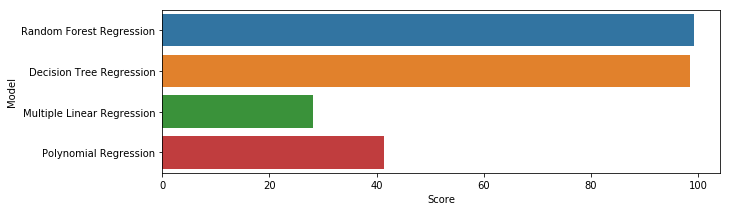

In [51]:

plt.figure(figsize= (10,3))
sns.barplot(results_regression['Score'],results_regression['Model']);

##  Conclusion 

Random Forest Regressor is the best regression model for predition of the ambient temprature.

# Classifiers

In [52]:
namec = []
scorec = []
f1 = []

We will assume:

- ambient temp <= 0 as "Low"
- ambient temp >0  as "High"

In [53]:
def ambient(x):
    if (x <= 0):
        return 'Low'
    else:
        return 'High'
    
df['ambient'] = df['ambient'].apply(ambient)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [54]:

df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,Low,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,Low,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,Low,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,Low,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,Low,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145


In [55]:

X = df.iloc[:,1:12].values
y = df.iloc[:,0:1].values

In [56]:
y

array([['Low'],
       ['Low'],
       ['Low'],
       ...,
       ['Low'],
       ['Low'],
       ['Low']], dtype=object)

In [57]:
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, ..., 1, 1, 1])

## Logistic Regression

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.35,random_state=1)

In [59]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [60]:
y_proba = classifier.predict_proba(X_train)
y_proba

array([[0.46530654, 0.53469346],
       [0.60697707, 0.39302293],
       [0.7646908 , 0.2353092 ],
       ...,
       [0.54604694, 0.45395306],
       [0.24901306, 0.75098694],
       [0.68047616, 0.31952384]])

In [61]:
y_predict_train = classifier.predict(X_train)
y_predict_train

array([1, 0, 0, ..., 0, 1, 0])

In [62]:
y_train

array([1, 0, 1, ..., 1, 1, 0])

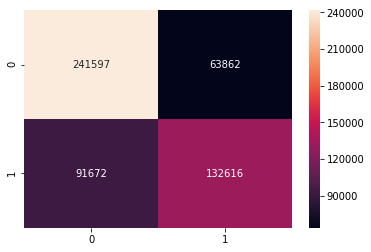

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot=True, fmt="d")

In [64]:
y_predict_test = classifier.predict(X_test)
y_predict_test

array([1, 0, 1, ..., 1, 0, 0])

In [65]:
y_test

array([0, 0, 0, ..., 1, 0, 1])

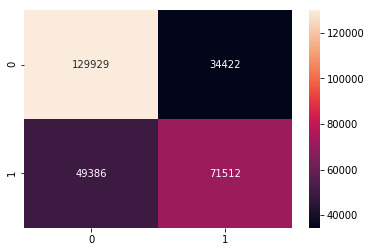

In [66]:
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True, fmt="d")

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.72      0.79      0.76    164351
           1       0.68      0.59      0.63    120898

   micro avg       0.71      0.71      0.71    285249
   macro avg       0.70      0.69      0.69    285249
weighted avg       0.70      0.71      0.70    285249



In [68]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_predict_test)
print('Logistic Regression:', acc * 100)


Logistic Regression: 70.61935361736587


In [69]:
from sklearn.metrics import f1_score
f = f1_score(y_predict_test,y_test,average='weighted')

In [70]:
namec.append('Logistic Regression')
scorec.append(acc)
f1.append(f)

## K- Nearest Neighbor Classifier

In [71]:
k_range = np.arange(1, 35)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
print(scores.index(max(scores)), max(scores))

0 0.9884592058166725


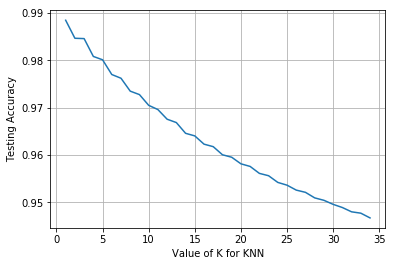

In [72]:
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.grid(True)

In [73]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [74]:
y_pred = classifier.predict(X_train)
y_pred

array([1, 0, 1, ..., 1, 1, 0])

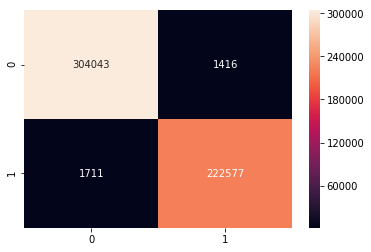

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [76]:
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 1])

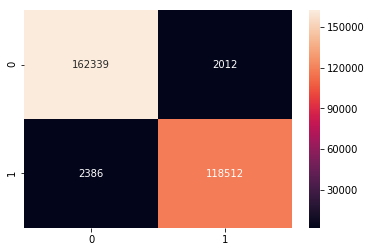

In [77]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    164351
           1       0.98      0.98      0.98    120898

   micro avg       0.98      0.98      0.98    285249
   macro avg       0.98      0.98      0.98    285249
weighted avg       0.98      0.98      0.98    285249



In [79]:
from sklearn.metrics import accuracy_score
accc = accuracy_score(y_test, y_pred)
print('Knn :',accc * 100)


Knn : 98.45818916104876


In [80]:
from sklearn.metrics import f1_score
g = f1_score(y_pred,y_test,average='weighted')

In [81]:
namec.append('K-Nearest Neighbors Classifier')
scorec.append(accc)
f1.append(g)

## Naive Bayes Classifier

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [83]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [84]:
y_pred = classifier.predict(X_train)
y_pred

array([1, 1, 0, ..., 0, 1, 1])

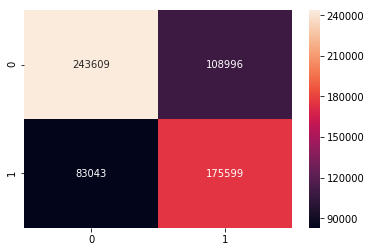

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [86]:
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 1, 1])

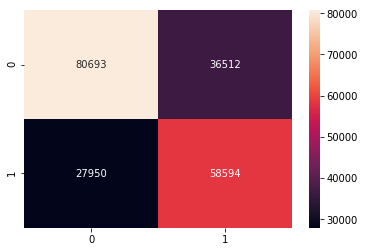

In [87]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71    117205
           1       0.62      0.68      0.65     86544

   micro avg       0.68      0.68      0.68    203749
   macro avg       0.68      0.68      0.68    203749
weighted avg       0.69      0.68      0.69    203749



In [89]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print('Naive Bayes:', acc * 100)


Naive Bayes: 68.3620533106911


In [90]:
from sklearn.metrics import f1_score
h = f1_score(y_pred,y_test,average='weighted')

In [91]:
namec.append('Naive Bayes Classifier')
scorec.append(acc)
f1.append(h)

## Decision Tree Classifier

In [92]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [93]:
# Feature Scaling
# Not required because decision trees are not based on eculidian distances
# Only left here for visualization purposes, remove after visualization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [94]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [95]:
# Predicting the Test set results
y_pred = classifier.predict(X_train)

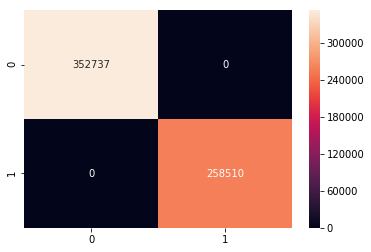

In [96]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [97]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

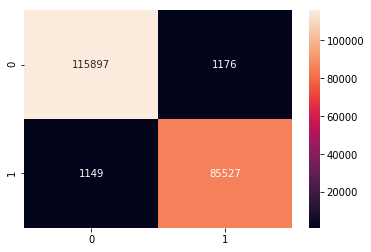

In [98]:

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    117073
           1       0.99      0.99      0.99     86676

   micro avg       0.99      0.99      0.99    203749
   macro avg       0.99      0.99      0.99    203749
weighted avg       0.99      0.99      0.99    203749



In [100]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print('Decision Tree:',acc * 100)


Decision Tree: 98.85889010498211


In [101]:
from sklearn.metrics import f1_score
i = f1_score(y_pred,y_test,average='weighted')

In [102]:
namec.append('Decision Tree Classifier')
scorec.append(acc)
f1.append(i)

In [103]:
results_classification = pd.DataFrame(scorec,index=namec,columns=['Score'])
results_classification['F1 Score'] = f1
results_classification = results_classification.reset_index()

In [104]:
results_classification['Model'] = results_classification['index']
results_classification.drop('index',axis=1,inplace=True)
results_classification

,Score,F1 Score,Model
0,0.706194,0.709488,Logistic Regression
1,0.984582,0.984585,K-Nearest Neighbors Classifier
2,0.683621,0.682161,Naive Bayes Classifier
3,0.988589,0.988589,Decision Tree Classifier


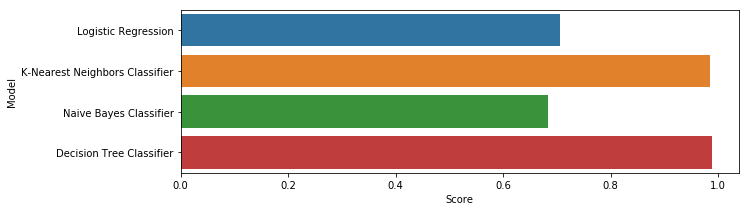

In [105]:
plt.figure(figsize= (10,3))
sns.barplot(results_classification['Score'],results_classification['Model']);

## Conclusion 

Decision Tree Classifier is the best classification model for predition of the ambient temprature.